In [16]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re

img_dir = "small_data/original"
mask_dir = "small_data/ground_truth"
# subdirs = ["train", "valid", "test"]

In [42]:
mask_pattern_const = r"SEM_adult_gj_segmentation_WL.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png"
img_pattern_const = r"Dataset8_export_s(\d+)_Y(\d+)_X(\d+).png"
def get_z_y_x(file_name, pattern):
    """ get z, y, x from file name (uses basename of file_name)"""
    file_name = os.path.basename(file_name)
    match = re.match(pattern, file_name)
    if match:
        if len(match.groups()) != 3:
            return None
        z, y, x = match.groups()
        return int(z), int(y), int(x)
    else:
        return None
    
def get_img_by_coords(z, y, x, img_files, img_pattern):
    """ get path of image by z, y, x """
    for i in range(len(img_files)):
        img_file = img_files[i]
        z_, y_, x_ = get_z_y_x(img_file, img_pattern)
        if z == z_ and y == y_ and x == x_:
            return cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    return None

def get_3d_slice(z,y,x, img_files, mask_files, img_pattern, mask_pattern, depth=1, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    Args:
        z: int, z coordinate
        y: int, y coordinate
        x: int, x coordinate
        img_files: list of str, paths to images
        mask_files: list of str, paths to masks
        img_pattern: str, pattern to extract z, y, x from image file name
        mask_pattern: str, pattern to extract z, y, x from mask file name
        depth: int, how many slices to include above and below the center slice
        width: int, width of each slice
        height: int, height of each slice
    """
    img_3d = np.zeros((2*depth+1, width, height))
    mask_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        mask = get_img_by_coords(z_coord, y, x, mask_files, mask_pattern)
        if img is not None and mask is not None:
            img_3d[i+depth] = img
            mask_3d[i+depth] = mask
    return img_3d, mask_3d

In [43]:
# sort the files by z, y, x (ensure that img and mask files are in the same order)
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)
mask_pattern = r"z(\d+)_y(\d+)_x(\d+).png"
img_pattern = r"z(\d+)_y(\d+)_x(\d+).png"
mask_files.sort(key=lambda x: get_z_y_x(x, mask_pattern))
img_files.sort(key=lambda x: get_z_y_x(x, img_pattern))
img_files = [os.path.join(img_dir, f) for f in img_files]
mask_files = [os.path.join(mask_dir, f) for f in mask_files]
print(img_files[:10])
print(mask_files[:10])

['small_data/original/z200_y7_x17.png', 'small_data/original/z200_y7_x18.png', 'small_data/original/z200_y8_x16.png', 'small_data/original/z200_y8_x17.png', 'small_data/original/z200_y8_x18.png', 'small_data/original/z200_y9_x15.png', 'small_data/original/z200_y9_x16.png', 'small_data/original/z200_y9_x17.png', 'small_data/original/z200_y10_x15.png', 'small_data/original/z200_y10_x16.png']
['small_data/ground_truth/z200_y7_x17.png', 'small_data/ground_truth/z200_y7_x18.png', 'small_data/ground_truth/z200_y8_x16.png', 'small_data/ground_truth/z200_y8_x17.png', 'small_data/ground_truth/z200_y8_x18.png', 'small_data/ground_truth/z200_y9_x15.png', 'small_data/ground_truth/z200_y9_x16.png', 'small_data/ground_truth/z200_y9_x17.png', 'small_data/ground_truth/z200_y10_x15.png', 'small_data/ground_truth/z200_y10_x16.png']


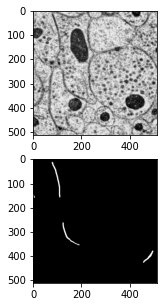

In [55]:
# sanity check: test that image and mask actually match
num = 20
z,y,x= get_z_y_x(img_files[num].split('/')[-1], img_pattern)
tmp_img = get_img_by_coords(z, y, x, img_files, img_pattern)
tmp_mask = get_img_by_coords(z, y, x, mask_files, mask_pattern)
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].imshow(tmp_img, cmap='gray')
ax[1].imshow(tmp_mask, cmap='gray')

(5, 512, 512) (5, 512, 512)


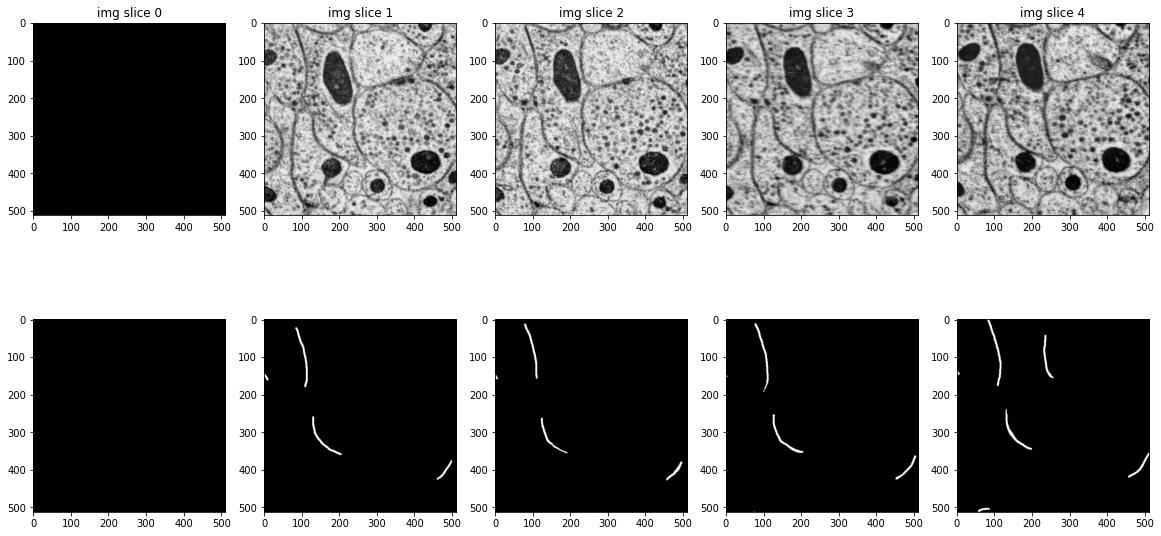

In [63]:
# 3d slice sanity check
depth = 2
img_3d, mask_3d = get_3d_slice(z, y, x, img_files, mask_files, img_pattern, mask_pattern, depth=2)
print(img_3d.shape, mask_3d.shape)
fig, ax = plt.subplots(2, 2*depth+1, figsize=(20, 10))
for i in range(2*depth+1):
    ax[0, i].imshow(img_3d[i], cmap='gray')
    ax[1, i].imshow(mask_3d[i], cmap='gray')
    ax[0, i].set_title(f"img slice {i}")
plt.show()

In [65]:
print(len(img_files), len(mask_files))

243 242


In [66]:
# save 3d slices
depth = 2 # (5, 512, 512)
for i in range(len(img_files)):
    z, y, x = get_z_y_x(img_files[i], img_pattern)
    img_3d, mask_3d = get_3d_slice(z, y, x, img_files, mask_files, img_pattern, mask_pattern, depth=depth)
    img_3d = img_3d.astype(np.uint8)
    mask_3d = mask_3d.astype(np.uint8)
    np.save(f"small_data_3d/original/{z}_{y}_{x}.npy", img_3d)
    np.save(f"small_data_3d/ground_truth/{z}_{y}_{x}.npy", mask_3d)
    print(f"saved {z}_{y}_{x}.npy | progress: {i/len(img_files)*100:.2f}%")

saved 200_7_17.npy | progress: 0.00%
saved 200_7_18.npy | progress: 0.41%
saved 200_8_16.npy | progress: 0.82%
saved 200_8_17.npy | progress: 1.23%
saved 200_8_18.npy | progress: 1.65%
saved 200_9_15.npy | progress: 2.06%
saved 200_9_16.npy | progress: 2.47%
saved 200_9_17.npy | progress: 2.88%
saved 200_10_15.npy | progress: 3.29%
saved 200_10_16.npy | progress: 3.70%
saved 200_12_17.npy | progress: 4.12%
saved 200_13_17.npy | progress: 4.53%
saved 200_13_18.npy | progress: 4.94%
saved 200_13_19.npy | progress: 5.35%
saved 200_13_20.npy | progress: 5.76%
saved 200_13_23.npy | progress: 6.17%
saved 201_7_16.npy | progress: 6.58%
saved 201_7_17.npy | progress: 7.00%
saved 201_7_18.npy | progress: 7.41%
saved 201_8_16.npy | progress: 7.82%
saved 201_8_17.npy | progress: 8.23%
saved 201_8_18.npy | progress: 8.64%
saved 201_9_15.npy | progress: 9.05%
saved 201_9_16.npy | progress: 9.47%
saved 201_9_17.npy | progress: 9.88%
saved 201_10_15.npy | progress: 10.29%
saved 201_10_16.npy | progre

libpng error: Read Error


saved 212_8_18.npy | progress: 86.01%
saved 212_9_16.npy | progress: 86.42%
saved 212_9_17.npy | progress: 86.83%
saved 212_12_17.npy | progress: 87.24%
saved 212_13_17.npy | progress: 87.65%
saved 212_13_19.npy | progress: 88.07%
saved 212_14_19.npy | progress: 88.48%
saved 212_14_20.npy | progress: 88.89%
saved 212_14_21.npy | progress: 89.30%
saved 212_15_21.npy | progress: 89.71%
saved 213_7_16.npy | progress: 90.12%
saved 213_7_17.npy | progress: 90.53%
saved 213_7_18.npy | progress: 90.95%
saved 213_8_15.npy | progress: 91.36%
saved 213_8_16.npy | progress: 91.77%
saved 213_8_17.npy | progress: 92.18%
saved 213_8_18.npy | progress: 92.59%
saved 213_9_16.npy | progress: 93.00%


libpng error: Read Error


saved 213_9_17.npy | progress: 93.42%
saved 213_12_17.npy | progress: 93.83%
saved 213_13_17.npy | progress: 94.24%
saved 213_13_18.npy | progress: 94.65%
saved 213_13_19.npy | progress: 95.06%
saved 213_14_19.npy | progress: 95.47%
saved 213_14_20.npy | progress: 95.88%
saved 213_14_21.npy | progress: 96.30%
saved 213_15_21.npy | progress: 96.71%
saved 214_7_16.npy | progress: 97.12%
saved 214_7_17.npy | progress: 97.53%
saved 214_7_18.npy | progress: 97.94%
saved 214_8_15.npy | progress: 98.35%
saved 214_8_16.npy | progress: 98.77%
saved 214_8_17.npy | progress: 99.18%
saved 214_8_18.npy | progress: 99.59%


libpng error: Read Error


In [67]:
files = os.listdir("small_data_3d/original")
print(len(files)) # 243 training samples (some may overlap a bit, fine for now)

243


In [68]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages')